In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import GridSearchCV,train_test_split

In [2]:
fraud_data = pd.read_csv('Fraud_check.csv')
fraud_data

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


### data understanding

In [3]:
fraud_data.isna().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [4]:
fraud_data.dtypes

Undergrad          object
Marital.Status     object
Taxable.Income      int64
City.Population     int64
Work.Experience     int64
Urban              object
dtype: object

In [5]:
fraud_data.Undergrad.unique()

array(['NO', 'YES'], dtype=object)

In [6]:
fraud_data['Marital.Status'].unique()

array(['Single', 'Divorced', 'Married'], dtype=object)

In [7]:
fraud_data.Urban.unique()

array(['YES', 'NO'], dtype=object)

**treating those who have taxable_income <= 30000 as "Risky" and others are "Good"**

In [8]:
fraud_df = fraud_data.copy()

In [9]:
fraud_df['income'] = fraud_df['Taxable.Income'].apply(lambda x: 'Risky' if x <= 30000 else 'Good')

In [10]:
# fraud_df["income"]="<=30000"
# fraud_df.loc[fraud_df["Taxable.Income"]>=30000,"income"]="Good"
# fraud_df.loc[fraud_df["Taxable.Income"]<=30000,"income"]="Risky"

In [11]:
fraud_df

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,income
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good
...,...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES,Good
596,YES,Divorced,69967,55369,2,YES,Good
597,NO,Divorced,47334,154058,0,YES,Good
598,YES,Married,98592,180083,17,NO,Good


In [12]:
fraud_df.income.unique()

array(['Good', 'Risky'], dtype=object)

In [13]:
fraud_df.rename(columns={'Marital.Status':'Marital','City.Population':'City_population','Work.Experience':'Work_experience'},inplace=True)
fraud_df.columns

Index(['Undergrad', 'Marital', 'Taxable.Income', 'City_population',
       'Work_experience', 'Urban', 'income'],
      dtype='object')

In [14]:
fraud_df.drop(labels = ['Taxable.Income'], axis = 1,inplace=True)
fraud_df.head()

,Undergrad,Marital,City_population,Work_experience,Urban,income
0,NO,Single,50047,10,YES,Good
1,YES,Divorced,134075,18,YES,Good
2,NO,Married,160205,30,YES,Good
3,YES,Single,193264,15,YES,Good
4,NO,Married,27533,28,NO,Good


In [15]:
le = LabelEncoder()
fraud_df['Undergrad'] = le.fit_transform(fraud_df['Undergrad'])
fraud_df['Marital'] = le.fit_transform(fraud_df['Marital'])
fraud_df['Urban'] = le.fit_transform(fraud_df['Urban'])
fraud_df['income'] = le.fit_transform(fraud_df['income'])

In [16]:
fraud_df

,Undergrad,Marital,City_population,Work_experience,Urban,income
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0
...,...,...,...,...,...,...
595,1,0,39492,7,1,0
596,1,0,55369,2,1,0
597,0,0,154058,0,1,0
598,1,1,180083,17,0,0


In [17]:
fraud_df['income'].value_counts()

0    476
1    124
Name: income, dtype: int64

In [18]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Undergrad        600 non-null    int64
 1   Marital          600 non-null    int64
 2   City_population  600 non-null    int64
 3   Work_experience  600 non-null    int64
 4   Urban            600 non-null    int64
 5   income           600 non-null    int64
dtypes: int64(6)
memory usage: 28.2 KB


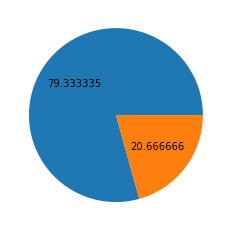

In [19]:
plt.pie(x = fraud_df['income'].value_counts(),autopct='%2f')
plt.show()

**output is imbalanced**

### Model Building

In [20]:
X = fraud_df.iloc[:,:-1]
y = fraud_df.iloc[:,-1:]

In [21]:
std_scale = StandardScaler()
scaled_X = std_scale.fit_transform(X)
scaled_X = pd.DataFrame(data = scaled_X,columns=X.columns)
scaled_X

,Undergrad,Marital,City_population,Work_experience,Urban
0,-1.040833,1.160800,-1.178521,-0.629143,0.993355
1,0.960769,-1.274445,0.508500,0.276370,0.993355
2,-1.040833,-0.056822,1.033109,1.634639,0.993355
3,0.960769,1.160800,1.696831,-0.063197,0.993355
4,-1.040833,-0.056822,-1.630532,1.408261,-1.006689
...,...,...,...,...,...
595,0.960769,-1.274445,-1.390432,-0.968710,0.993355
596,0.960769,-1.274445,-1.071672,-1.534655,0.993355
597,-1.040833,-1.274445,0.909696,-1.761033,0.993355
598,0.960769,-0.056822,1.432197,0.163181,-1.006689


In [22]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X,y, random_state=12,test_size=0.20,stratify=y)

In [23]:
X_train.shape,X_test.shape

((480, 5), (120, 5))

### model testing ,training and evaluation

In [31]:
y_train.value_counts()

income
0         381
1          99
dtype: int64

In [48]:
dt_classifier = DecisionTreeClassifier(max_depth=3,class_weight={1:3})
dt_classifier.fit(X_train,y_train)
y_pred_test = dt_classifier.predict(X_test)
print('ACCURANCY    : ',accuracy_score(y_test,y_pred_test))
print('PRECISION    : ',precision_score(y_test,y_pred_test))
print('RECALL       : ',recall_score(y_test,y_pred_test))
print('ROC          : ',roc_auc_score(y_test,y_pred_test))
print(confusion_matrix(y_test,y_pred_test))

ACCURANCY    :  0.7666666666666667
PRECISION    :  0.2
RECALL       :  0.04
ROC          :  0.49894736842105264
[[91  4]
 [24  1]]


In [27]:
dt_classifier = DecisionTreeClassifier(max_depth=3,class_weight={1:2})
dt_classifier.fit(X_train,y_train)
y_pred_train = dt_classifier.predict(X_train)
print('ACCURANCY    : ',accuracy_score(y_train,y_pred_train))
print('PRECISION    : ',precision_score(y_train,y_pred_train))
print('RECALL       : ',recall_score(y_train,y_pred_train))
print('ROC          : ',roc_auc_score(y_train,y_pred_train))

ACCURANCY    :  0.7875
PRECISION    :  0.42105263157894735
RECALL       :  0.08080808080808081
ROC          :  0.5259683448659827


In [49]:
# grid_cv = GridSearchCV(estimator=dt_classifier, param_grid={
#                       'max_depth': range(0,15),
#                       'splitter' : ('best', 'random'),
#                       'max_features':range(0,6),
#                       'class_weight':[{1: w} for w in range(0,5)]})
# grid_cv.fit(X_train,y_train)

**we got our model at 76% accuracy for test data**